# Overview
The goal of this assignment is a basic introduction into how common tasks like reading and manipulating data, including basic operations like interpolation, array multiplication, filtering, and plotting. The assignment requires the following python packages:
- numpy
- scipy
- matplotlib


# Read the data
Neuroscience experiments typically produce a a variety of signals, often from different data sources with different sampling rates and in a number of different file formats. The goal of this excercise is to read data in four widely-used formats:

npy -- numpy file  (numpy load)
csv -- text file with comma-seperated values (numpy loadtxt)
bin -- binary file  (numpy fromfile)
mat -- matlab file (scipy's loadmat function)

There are four example files (one for each data format) located in the same directory as this notebook (file names: signal1.npy, signal2.csv, signal3.bin, signal4.mat). Read the data from the different files into numpy arrays. Note that some signals have more than one channel and therefore need to be stored into a matrix. The sampling rates for npy, csv, and bin files are 25 Hz, 100 Hz, and 300 Hz, respectively. All data are double precision (float64 in numpy), start at time 0, and time increases along rows. 

The binary file contains multiple channels stored as a sequence of bytes. Thus the data must be reshaped into a matrix taking into account the ordering of the values in the array. There are two different ways of writing a 2D array (matrix) into a binary file: row-major order (often called "C" order, used in C) or column-major order (Fortran order, used in Fortran and Matlab). The data in the bin file were written in C order. 

Note that the mat file preserves the ordering of the matrix entries so no further reshaping is needed for this file. However, the resulting matrix will be in Fortran order in memory which is relevant when using numpy functions like ravel(). It might therefore be a good idea to convert the data into a matrix with row-major order. In general, every numpy array has a "flags" property showing information about ordering, alignment etc.

In [2]:
import os.path as op  # useful for system-independent handling of paths

# read numpy file (1 channel)
import numpy as np
signal1 = np.load(op.join('resources', 'signal1.npy'))
fs1 = 25.
n1 = signal1.shape[0]
t1 = np.arange(n1) / fs1
print("numpy signal -- # samples: {}, samplerate: {:.1f}, duration: {:.2f}".format(n1, fs1, t1.max()))

# read csv file (1 channel)
signal2 = np.loadtxt(op.join('resources', 'signal2.csv'), delimiter=',', dtype=np.float64)
fs2 = 100.
n2 = signal2.shape[0]
t2 = np.arange(n2) / fs2
print("csv signal -- # samples: {}, samplerate: {:.1f}, duration: {:.2f}".format(n2, fs2, t2.max()))

# read bin file (4 channels)
tmp = np.fromfile(op.join('resources', 'signal3.bin'), dtype=np.float64)
fs3 = 300.
n_channels = 4
n3 = int(tmp.shape[0] / n_channels)

signal3 = np.reshape(tmp, (n3, n_channels))
t3 = np.arange(n3) / fs3
print("bin signal -- # samples: {}, samplerate: {:.1f}, duration: {:.2f}".format(n3, fs3, t3.max()))

# mat file (2 channels)
from scipy.io import loadmat
tmp = loadmat(op.join('resources', 'signal4.mat'))
signal4 = tmp['data']
fs4 = float(tmp['samplerate'])
n4 = signal4.shape[0]
t4 = np.arange(n4) / fs4
print("mat signal -- # samples: {}, samplerate: {:.1f}, duration: {:.2f}".format(n4, fs4, t4.max()))


numpy signal -- # samples: 250, samplerate: 25.0, duration: 9.96
csv signal -- # samples: 1000, samplerate: 100.0, duration: 9.99
bin signal -- # samples: 3000, samplerate: 300.0, duration: 10.00
mat signal -- # samples: 5000, samplerate: 500.0, duration: 10.00


# Interpolate to the same sampling frequency
For the analysis it can be extremely useful to resample all data collected in an experiment to the same sampling rate (i.e. same time scale) to be able to compute important quantities like the cross-correlation between the signals. Resampling is a research topic on its own and often it is sufficient to simply interpolate the signals. Scipy has an interpolation function (interp1d) that can be used to interpolate along a single dimension (here: time), even if the array has multiple dimensions (e.g., 2 for a matrix). Use linear interpolation to resample all signals to a sampling rate of 100 Hz. Moreover, collect all data in one matrix **X** with time increasing along rows and channels along columns. Numpy has a number of special functions for this (concatenate, hstack, vstack etc).

In [3]:
from scipy.interpolate import interp1d

# time base for all signals
fs = 100.
t_max = min([t1.max(), t2.max(), t3.max(), t4.max()])
N = int(round(t_max * fs))
t = np.arange(N) / fs

fi1 = interp1d(t1, signal1, kind='linear')
fi2 = interp1d(t2, signal2, kind='linear')
fi3 = interp1d(t3, signal3, kind='linear', axis=0)
fi4 = interp1d(t4, signal4, kind='linear', axis=0)

x1 = fi1(t)
x2 = fi2(t)
x3 = fi3(t)
x4 = fi4(t)

X = np.column_stack((x1, x2, x3, x4))
print('data matrix dimensions:', X.shape)


data matrix dimensions: (996, 8)


# Weight the dataset in 4 different ways (and time everything)
The person that collected the data found out that the amplifier gains for the different signals were wrong and this need to be accounted for during the analysis. The correct gain factors are:

npy file: 1
csv file: 2
bin file: 3
mat file: 4

Of course, one could simply apply the correct gain factors when reading the data. However, the goal here is to apply the gain factors to the elements of the full data matrix created in the previous problem to learn about fundamental array concepts like indexing, slicing, and broadcasting. Try to weight the different channels in the following ways:

1. **Element-wise:** this will require at least two for loops to apply the gain factors to each matrix element X[i, j] where i is increasing along time dimension and j is the column index. Note that some signals have multiple channels so j+1 might still require the same gain factor as j. An extensive description of numpy array indexing can be found here:
https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html.

2. **Slicing:** an extension of Python's slicing (e.g., L[:] for lists) to multiple dimensions; this will require at least 1 for loop and will involve the slicing operation *X[:, j] (i.e. all rows for column j)

3. **Array multiplication:** weighting the elements of a matrix by the values in a vector is nothing else than basic linear algebra. However, in contrast to Matlab matrix multiplication in numy is slightly different. The results of A * B (where A and B are some matrices with the right dimensions) will not be the dot product but an element-wise multiplication of both matrices (also known as Schur or Hadamard product). The standard dot product is implemented in numpy by the function dot(A, B). In both cases you will have to create a second matrix containing the gain factors in the appropriate order/shape.

4. **Broadcasing:** broadcasting is a powerful concept that can considerably simplify operations and make code much more readable. The basic idea is that the dimension(s) of arrays are reshaped for specific operations. There are two different typpes of broadcasting
    - Explicit broadcasting: see numpy's broadcast function
    - Implicit Broadcasting: see https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    In this example, broadcasting will allow you to perform the weighting of the data matrix in a single line of code.

In [4]:
gain_factors = np.array([1, 2, 3, 3, 3, 3, 4, 4], dtype=np.float64)

N, n_channels = X.shape

# 1. element-wise
X1 = np.copy(X)  # work on copy of signal array
for i in range(N):
    for j in range(n_channels):
        X1[i, j] *= gain_factors[j]  # the same as X1[i, j] = X[i, j] * gain_factors[j]

# 2. slicing
X2 = np.zeros_like(X)
for j in range(n_channels):
    X2[:, j] = X[:, j] * gain_factors[j]

# 3. array multiplication
G = np.tile(gain_factors, (N, 1)) # create matrix of same size as X
X3_1 = X * G  # element-wise multiplication (schur product)

D = np.diag(gain_factors)  # matrix with gain factors on its diagonal
X3_2 = np.dot(X, D)  # matix multiplication

# 4. broadcasting
b = np.broadcast(X, gain_factors)
X4_1 = np.reshape([i*j for i, j in b], (N, n_channels))

X4_2 = X * gain_factors  # implicit broadcasting

for x in [X1, X2, X3_1, X3_2, X4_1]:
    print(np.allclose(X4_2, x))


True
True
True
True
True


# Filter
The relevant information we want to extract from a signal is often in a specific frequency range. For example, to extract local field potentials (LFP) and action potentials (spikes) from electrophysiological neural recordings were usually use the frequency range of 1-100 Hz and 500 - 5000 Hz, respectively. This requires filtering of the signals. Scipy has a number of filter generation and filtering functions (in scipy.signal). Use these functions to filter the data in the matrix **X** (along its time dimension) using 2nd order Butterworth lowpass filter (higher cutoff: 20 Hz) and zero-phase filtering (aka forward-backward filtering). Do not overwrite the original data matrix but save the output to a new matrix Y.

In [5]:
from scipy.signal import butter, filtfilt

f_cutoff = 20.

# create digital filter coefficients
order = 2
wn = f_cutoff / fs
b, a = butter(order, wn, btype='low', analog=False, output='ba')
print("filter coefficients", "b:", b, "a:", a)

# filter signal
Y = filtfilt(b, a, X, axis=0)

filter coefficients b: [ 0.06745527  0.13491055  0.06745527] a: [ 1.        -1.1429805  0.4128016]


# Plot
Use matplotlib's plotting functions to generate the following figures:

1. **Line plots:** plot the all signals (=columns) of X as a function of time (_plot_ function), each in a seperate axes. Add the lowpass filtered signals in Y on top of each corresponding plot (i.e. X[:, i] and Y[[:, i] in the same axes). Use different line colors for both signals. Add x/y axis labels and set 4 ticks on each axis.

2. **Scatter plots:** plot the different channels against each other using the _scatter_ plotting function, each in a separate axes. This can be very useful to look at correlations between variables (indeed, the linear fit corresponds to a linear correlation). Moreover, add a diagonal line.

3. **Image plots:** plot the whole matrix as a (pseudo-)image (_imshow_ function) in one axes. Try different interpolation modes, e.g., "bilinear" and "nearest". Moreover, try different color maps, e.g., "Greys", "viridis" (requires matplotlib version >= 2.0), and "jet". The data matrix is what we often call "tall and skinny" so it will require to set the aspect ratio (_aspect_ keyword argument).

4. **Histogram plots:** plot the distribution of values for each signal as a histogram (__hist__ function), each in a separate axes.

**Note:** a figure with different axes (e.g., one for each signal) can convienently be created using matplotlib's __subplots__ function, e.g., "fig, axarr = plt.subplots(nrows=2 ncols=4)" will create a figure (fig) and 10 axes (axarr) arranged in a 2 x 4 grid. "axarr" is a numpy array so the axes in the upper left corner can be obtained by axarr[0, 0] and the rightmost axes in the first row by axarr[0, 3] (or equivalently axarr[0, -1]). This allows to access the axes in a loop over the columns in **X**. To do so it might be useful to access the axes in "linear" order (C order, see above) by using axarr.flat[i].

**Another note:** matplotlib has an excellent documentation (https://matplotlib.org/) with even more useful examples (https://matplotlib.org/gallery/index.html).

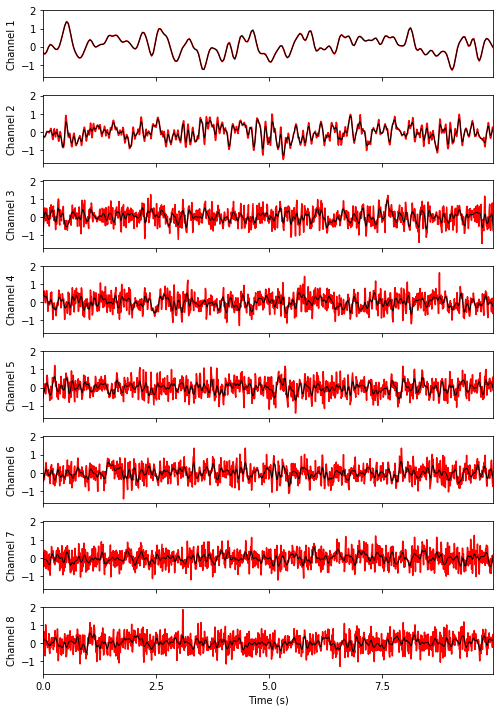

In [6]:
import matplotlib.pyplot as plt

# 1. line plots
fig, axarr = plt.subplots(nrows=n_channels, ncols=1, sharex=True, sharey=True)
for j in range(n_channels):

    ax = axarr[j]

    # plot raw and lowpass-filtered signal
    ax.plot(t, X[:, j], 'r-', lw=1.5)
    ax.plot(t, Y[:, j], 'k-', lw=1)

    # set axes labels
    if j == n_channels - 1:
        ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channel {}'.format(j+1))

    # set axes ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # set axes limits
    ax.set_xlim(t.min(), t.max())

fig.set_size_inches(7.1, 10)
fig.tight_layout()


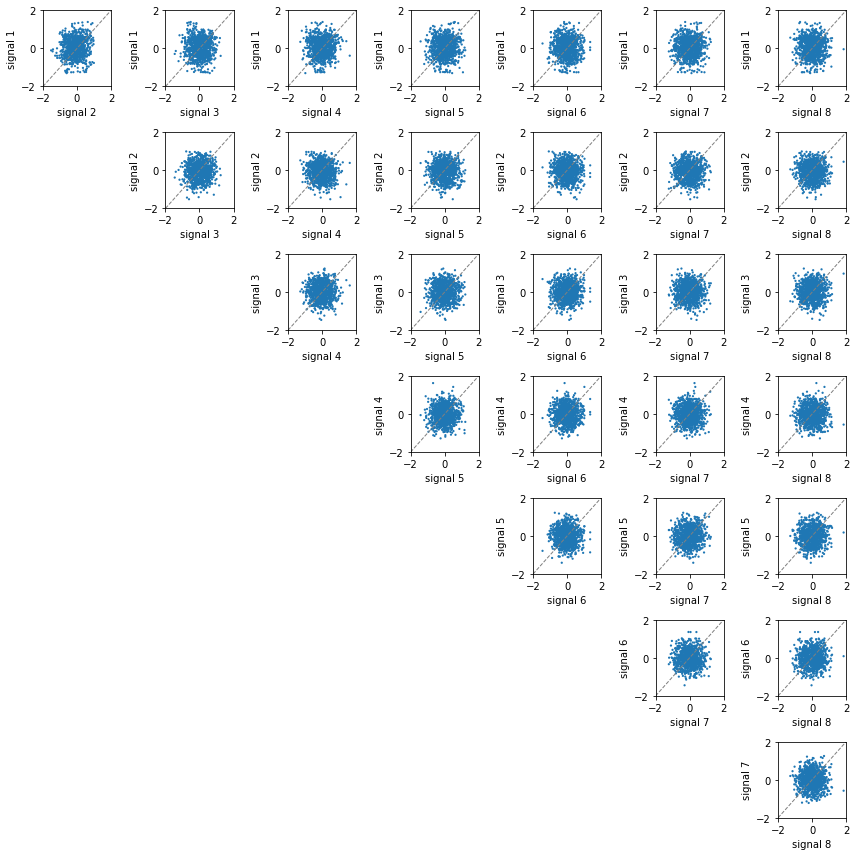

In [7]:
# 2. scatter plots

fig, axarr = plt.subplots(nrows=n_channels-1, ncols=n_channels-1)

# turn off all axes
[ax.axis('off') for ax in axarr.flat]

# data range
xmin = int(np.floor(X.min()))  # next smallest integer
xmax = int(np.ceil(X.max()))  # next largest integer

for i in range(n_channels):
    for j in range(i+1, n_channels):

        # turn "on" non-redundant axes
        ax = axarr[i, j-1]
        ax.axis('on')

        # scatter plot
        ax.scatter(X[:, j], X[:, i], s=5, edgecolors='none')

        # set labels, limits, and ticks
        ax.set_xlabel('signal {}'.format(j+1))
        ax.set_ylabel('signal {}'.format(i+1))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.set_xticks([xmin, 0, xmax])
        ax.set_yticks([xmin, 0, xmax])

        # diagonal line
        xx = np.linspace(xmin, xmax, 10)
        ax.plot(xx, xx, '--', color=3*[.5], lw=1)

fig.set_size_inches(12, 12)
fig.tight_layout()

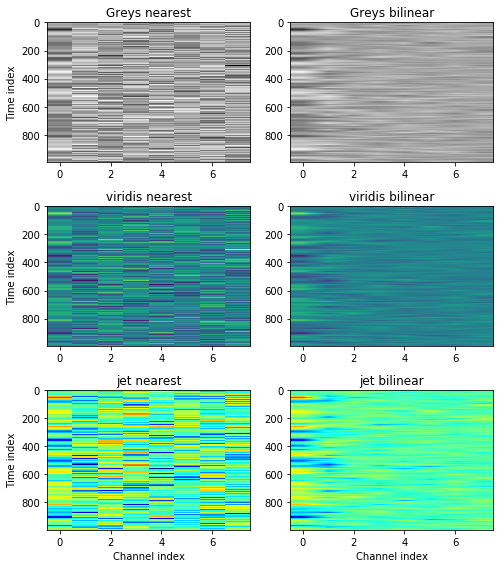

In [13]:
# 3. (pseudo-)image plots

fig, axarr = plt.subplots(nrows=3, ncols=2)
for i, cmap in enumerate(['Greys', 'viridis', 'jet']):
    for j, interp in enumerate(['nearest', 'bilinear']):

        ax = axarr[i, j]
        ax.set_title('{} {}'.format(cmap, interp))  # add title

        ax.imshow(X, interpolation=interp, cmap=cmap, aspect='auto')

        if i == 2:
            ax.set_xlabel('Channel index')
        if j == 0:
            ax.set_ylabel('Time index')

fig.set_size_inches(7.1, 8)
fig.tight_layout()

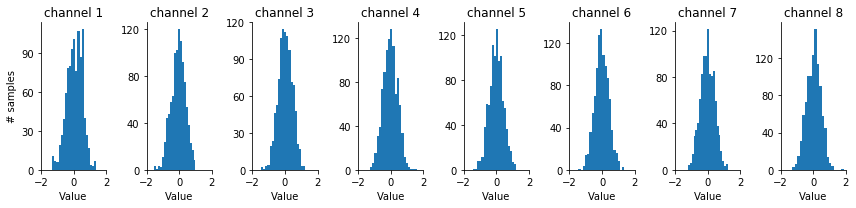

In [14]:
# 4. histograms

fig, axarr = plt.subplots(nrows=1, ncols=n_channels)

for i in range(n_channels):

    ax = axarr[i]
    ax.hist(X[:, i],
            bins=21)  # or set bin edges manually, e.g., bins=np.linspace(xmin, xmax, 21)

    # title and labels
    ax.set_title('channel {}'.format(i+1))
    ax.set_xlabel('Value')
    if i == 0:
        ax.set_ylabel('# samples')

    # ticks
    ax.set_xticks([xmin, 0, xmax])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # disable some "spines"
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.set_size_inches(12, 3)
fig.tight_layout()


# Save data
Finally, save the data matrix **X** in the following data formats:
1. numpy array (npy; numpy save)
2. csv file (csv; numpy savetxt)
3. binary file (bin; numpy tofile)
4. mat file (scipy savemat)

Make sure not to overwrite the existing data files!

In [15]:
# numpy file
np.save('x_matrix.npy', X)

# csv file
np.savetxt('x_matrix.csv', X, delimiter=',')

# binary file
X.tofile('x_matrix.bin')

# mat file
from scipy.io import savemat
savemat('x_matrix.mat', {'X': X})

# print file sizes
for ext in ['npy', 'csv', 'bin', 'mat']:
    print("file size {} format: {} kb".format(ext, op.getsize('x_matrix.' + ext)/1000.))

file size npy format: 63.872 kb
file size csv format: 203.146 kb
file size bin format: 63.744 kb
file size mat format: 63.928 kb
